# DATA EXPLORATION

Let's explore the given data.

In [36]:
import pandas as pd
import numpy as np

training = pd.read_csv('data/training.csv')
validation = pd.read_csv('data/validation.csv')

In [8]:
print(training.head())
print(validation.head())

   2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...     
   3364   Facebook Irrelevant  \
0   352     Amazon    Neutral   
1  8312  Microsoft   Negative   
2  4371      CS-GO   Negative   
3  4433     Google    Neutral   
4  6273       FIFA   Negative   

  I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣  
0

Seems like there is no header, let's add that with column names: ID, Topic, Sentiment, Tweet

In [37]:
training.columns = ['id', 'topic', 'sentiment', 'tweet']
validation.columns = ['id', 'topic', 'sentiment', 'tweet']

In [10]:
# lets see the topics we have and how many of them
print(training['topic'].nunique())
print(training['topic'].unique())

print(validation['topic'].nunique())
print(validation['topic'].unique())

32
['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia']
32
['Amazon' 'Microsoft' 'CS-GO' 'Google' 'FIFA' 'MaddenNFL'
 'TomClancysRainbowSix' 'AssassinsCreed' 'CallOfDuty' 'Dota2' 'Verizon'
 'NBA2K' 'Nvidia' 'GrandTheftAuto(GTA)' 'RedDeadRedemption(RDR)'
 'Hearthstone' 'ApexLegends' 'Overwatch'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Borderlands' 'PlayStation5(PS5)'
 'johnson&johnson' 'Fortnite' 'Xbox(Xseries)' 'CallOfDutyBlackopsColdWar'
 'Facebook' 'HomeDepot' 'Cyberpunk2077' 'TomClancysGhostRecon'
 'WorldOfCraft' 'LeagueOfLegends' 'Battlefield']


Qualitative investigation:
- The dataset has been subjected to data augmentation, since there are many versions of the same tweet with minor differences, possibly a dictionary-based replacement.
- The unknown token appears in some tweets with multiple forms: \<unk> and [UNK]
- There is an irrelevant class that needs further investigation.

Let's continue with cleaning unnecessary information.

In [38]:
# lets get rid of urls and handles in the tweets
import re

URL_PATTERN = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
HANDLE_PATTERN = r'@[\w]*'

def clean_tweet(tweet):
    tweet = re.sub(URL_PATTERN, '', tweet)
    tweet = re.sub(HANDLE_PATTERN, '', tweet)
    return tweet

def remove_empty(df):
    df = df.dropna()
    df = df[df['tweet'] != '']
    return df

print(f"Training before cleaning: {training.shape}")
print(f"Validation before cleaning: {validation.shape}")
training = remove_empty(training)
validation = remove_empty(validation)

training['tweet'] = training['tweet'].apply(clean_tweet)
validation['tweet'] = validation['tweet'].apply(clean_tweet)

# this can bring empty tweets, lets get rid of them
training = remove_empty(training)
validation = remove_empty(validation)

print(f"Training after cleaning: {training.shape}")
print(f"Validation after cleaning: {validation.shape}")

Training before cleaning: (74681, 4)
Validation before cleaning: (999, 4)
Training after cleaning: (73981, 4)
Validation after cleaning: (999, 4)


#### DUPLICATES

There are 2 types of duplicated tweets:
1) Duplicate in the whole row. (i.e. id, topic, sentiment, tweet all are the same)
2) Duplicate within/across topics with different sentiments.
    - I think the same tweet can appear with different sentiments across different topics. But not in the same topic!

In [39]:
# Remove duplicate type 1: duplicate in the whole row

print(f"Training before removing type 1 duplicates: {training.shape}")
print(f"Validation before removing type 1 duplicates: {validation.shape}")

training = training.drop_duplicates(keep='first')
validation = validation.drop_duplicates(keep='first')

print(f"Training after removing type 1 duplicates: {training.shape}")
print(f"Validation after removing type 1 duplicates: {validation.shape}")

Training before removing type 1 duplicates: (73981, 4)
Validation before removing type 1 duplicates: (999, 4)
Training after removing type 1 duplicates: (71641, 4)
Validation after removing type 1 duplicates: (999, 4)


In [40]:
# for type 2 duplicates, we will group the tweets by topic and remove duplicates in each group,
# we will keep the most occurring sentiment in the group
# if there are multiple sentiments with the same count, then the order is neutral, positive, negative, irrelevant


def remove_type_2_duplicates(df):
    CHOICE_ORDER = ['Neutral', 'Positive', 'Negative', 'Irrelevant']
    
    # get the duplicate tweets
    duplicates = df[df.duplicated(subset='tweet', keep=False)]

    # for each duplicate tweet, get the tweets with the same text and group them by topic
    to_remove_indices = []
    for tweet in duplicates['tweet'].unique():
        group = df[df['tweet'] == tweet].groupby('topic')
        for topic, group_df in group:
            if len(group_df) > 1:
                # get the most occurring sentiment
                sentiment_counts = group_df['sentiment'].value_counts()
                max_sentiment = sentiment_counts.max()
                max_sentiments = sentiment_counts[sentiment_counts == max_sentiment].index
            
                if len(max_sentiments) > 1:
                    # get the sentiment with the highest priority
                    max_sentiment = sorted(max_sentiments, key=lambda x: CHOICE_ORDER.index(x))[0]
                else:
                    max_sentiment = max_sentiments[0]

                # now we have the sentiment to keep, remove the other rows
                to_remove_indices.extend(group_df[group_df['sentiment'] != max_sentiment].index)

                # there can also be multiple rows with the same sentiment, keep the first one
                to_remove_indices.extend(group_df[group_df['sentiment'] == max_sentiment].iloc[1:].index)

    df = df.drop(to_remove_indices)
    return df

print(f"Training before removing type 2 duplicates: {training.shape}")
training = remove_type_2_duplicates(training)
print(f"Training after removing type 2 duplicates: {training.shape}")

print(f"Validation before removing type 2 duplicates: {validation.shape}")
validation = remove_type_2_duplicates(validation)
print(f"Validation after removing type 2 duplicates: {validation.shape}")

Training before removing type 2 duplicates: (71641, 4)
Training after removing type 2 duplicates: (70478, 4)
Validation before removing type 2 duplicates: (999, 4)
Validation after removing type 2 duplicates: (999, 4)


### SENTIMENT DISTRIBUTION

Sentiment distribution within the data is important for machine learning models, so that the models can have an equal concept of each class. Let's check what is the case for our data.

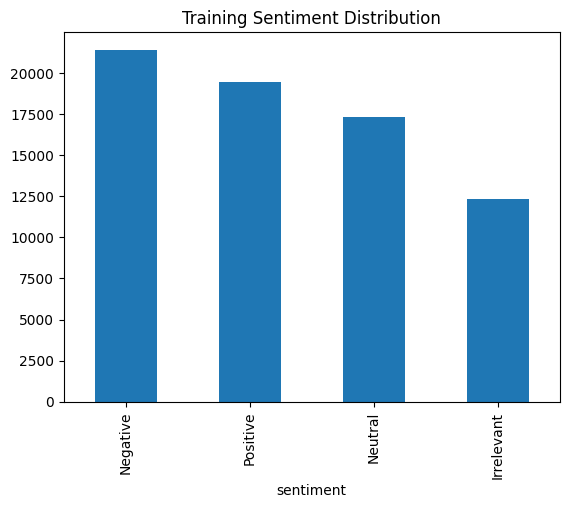

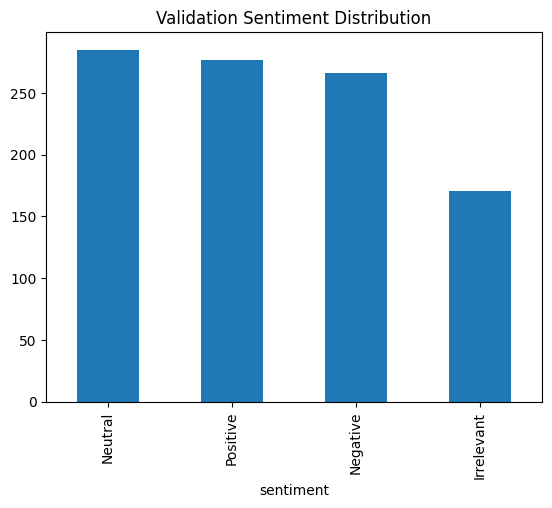

In [42]:
from matplotlib import pyplot as plt

training['sentiment'].value_counts().plot(kind='bar')
plt.title('Training Sentiment Distribution')
plt.show()


validation['sentiment'].value_counts().plot(kind='bar')
plt.title('Validation Sentiment Distribution')
plt.show()


Seems like the classes are not equally represented... What is the case within each topic?

Text(0.5, 1.0, 'Validation Sentiment Distribution by Topic')

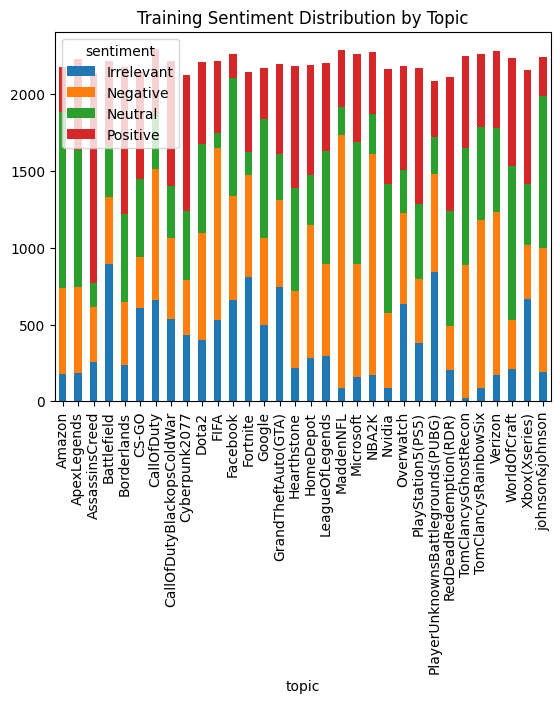

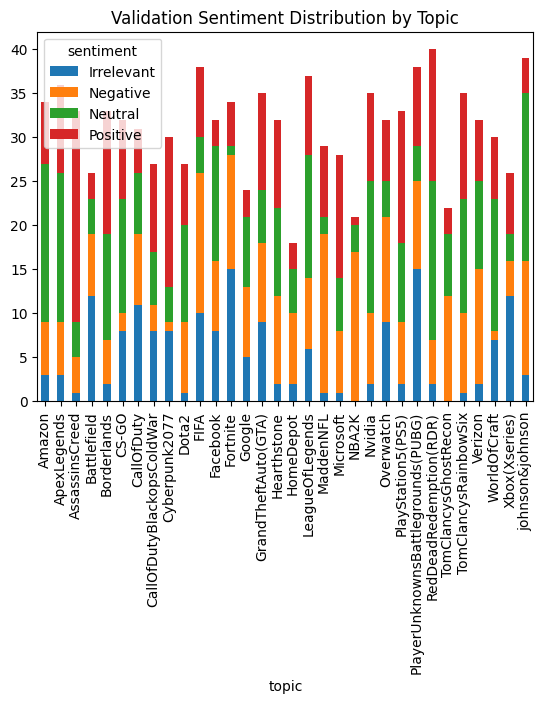

In [44]:
training.groupby('topic')['sentiment'].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title('Training Sentiment Distribution by Topic')

validation.groupby('topic')['sentiment'].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title('Validation Sentiment Distribution by Topic')

This is also the case within each topic, here we can also see that the least represented class is not always 'Irrelevant'. I'd suggest a balanced representation of each class by employing some custom sampling of the data.

### THE IRRELEVANT CLASS

What is actually this class? It is listed as a sentiment, but it is not really a sentiment... 

In [48]:
# list the irrelevant sentiments

irrelevant_training = training[training['sentiment'] == 'Irrelevant']

for index, row in irrelevant_training.iterrows():
    print(row['id'], row['topic'], row['tweet'])

2418 Borderlands Appreciate the (sonic) concepts / praxis Valenzuela and Landa-Posas thread together in this talk: multimodal listening, soundwalks, borderlands frameworks, participatory action research, and testimonios. . . So many thoughtful and resonant intersections here.. .  
2418 Borderlands Appreciate the (sound) concepts / practices that Valenzuela and Landa-Posas combine in this lecture: multimodal listening, soundwalks, borderland frameworks, participatory action research and testimonies... So many thoughtful and resonant intersections here...
2418 Borderlands Evaluate the (sound) concepts / concepts of Valensela and Landa Pozas together in this conversation: multimodal listening, walks, border areas, joint action studies, etc. So many amazing and resonant intersections here...
2418 Borderlands Appreciate the (sonic) concepts / praxis Valenzuela and Moreno-Posas have together in this talk: multimodal listening, soundwalks, borderlands recordings, participatory field research,

For the irrelevant class, I'd suggest we include the topic that the tweet is supposed to have a sentiment about. This way I think we can identify the irrelevant class more easily.

In [ ]:
# lets save the cleaned data
training.to_csv('data/cleaned_training.csv', index=False)
validation.to_csv('data/cleaned_validation.csv', index=False)